In [7]:
import modules
import math
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import plotly.express as px
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia


import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.rcParams['figure.figsize']=(16.,9.)

In [8]:
#from astroquery.gaia import Gaia
#Gaia.login()

#https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..11K/abstract
#https://ui.adsabs.harvard.edu/abs/2019A%26A...625A...5K/abstract

In [9]:
ra = 230.29273250927704
dec=-6.132573862818884

In [2]:
# Set the coordinates for the main star

ra = 230.29273250927704
dec=-6.132573862818884

# Request the start in the radious r around the main star

Jessicas_star = modules.get_stars (ra,dec, 0.19)
Jessicas_star

NameError: name 'modules' is not defined

In [6]:
# Use gal_uvw to calculate velocities 

U = []
V = []
W = []

for i in Jessicas_star:
    u, v, w = modules.gal_uvw(ra = i["ra"], dec = i["dec"], pmra = i["pmra"] , pmdec = i["pmdec"], vrad = i["dr2_radial_velocity"], plx = i["parallax"], lsr='yes')
    U.append(u)
    V.append(v)
    W.append(w)

#V = np.array(V) - [220] * len(V) #local standart of rest

T = np.sqrt(np.array(U)**2+np.array(W)**2)


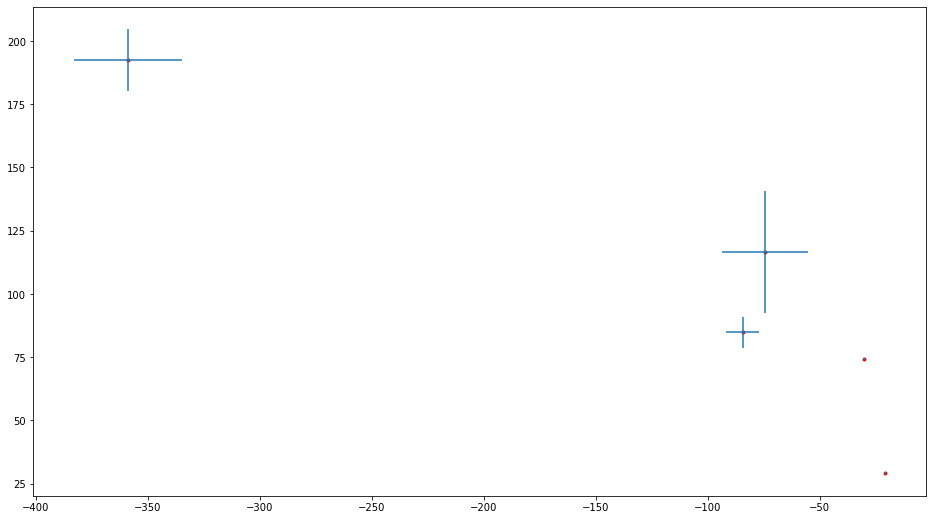

In [8]:
# Calculate error bars / re-run modules.gal_uvw with (parallax - parralax-error) and (parallax + parralax-error)
plx_lower = Jessicas_star["parallax"] - Jessicas_star["parallax_error"]
plx_upper = Jessicas_star["parallax"] + Jessicas_star["parallax_error"]

   
U_upper = []
V_upper = []
W_upper = []


for i in Jessicas_star:
    plx = i["parallax"] - i["parallax_error"]
    u, v, w = modules.gal_uvw(ra = i["ra"], dec = i["dec"], pmra = i["pmra"] , pmdec = i["pmdec"], vrad = i["dr2_radial_velocity"], plx = plx , lsr='yes')
    U_upper.append(u)
    V_upper.append(v)
    W_upper.append(w)
    
    
V_upper = np.array(V_upper) - [220] * len(V) #local standart of rest

T_upper = np.sqrt(np.array(U_upper)**2+np.array(W_upper)**2)


U_lower = []
V_lower = []
W_lower = []


for i in Jessicas_star:
    plx = i["parallax"] + i["parallax_error"]
    u, v, w = modules.gal_uvw(ra = i["ra"], dec = i["dec"], pmra = i["pmra"] , pmdec = i["pmdec"], vrad = i["dr2_radial_velocity"], plx = plx , lsr='yes')
    U_lower.append(u)
    V_lower.append(v)
    W_lower.append(w)
    
    
V_lower = np.array(V_lower) - [220] * len(V) #local standart of rest

T_lower = np.sqrt(np.array(U_lower)**2+np.array(W_lower)**2)

xerr = V_upper - V_lower
yerr = T_upper - T_lower

plt.scatter(V, T, marker='.', color='r')


plt.errorbar(V, T, xerr=xerr,yerr=yerr, linestyle="None")

plt.show()



In [25]:
# Query Halo Stars

halo_stars = modules.get_halo_stars (1000)

df_halo_stars = halo_stars.to_pandas()

#Apply gal_uvw

df_halo_stars["uvw"] = df_halo_stars.apply( \
        lambda row: \
            modules.gal_uvw( \
                row["ra"], \
                row["dec"], \
                row["dec"], \
                row["pmra"], \
                row["pmdec"], \
                row["dr2_radial_velocity"], \
                row["parallax"] \
            ), \
        axis=1 \
    )

#Calculate T

df_halo_stars["T"] = df_halo_stars.apply( \
        lambda row: np.sqrt(row['uvw'][0]**2+row['uvw'][2]**2),
        axis=1 \
    )

#Append values to the dataset 

df_halo_stars[['U', 'V', 'W']] = pd.DataFrame(df_halo_stars['uvw'].tolist(), index=df_halo_stars.index)

#Isolate based on velocity (cut out circle)

df_halo_stars["V-232"] = df_halo_stars.apply( \
        lambda row: abs(row['V'] - 232),
        axis=1 \
    )

df_halo_stars = df_halo_stars[df_halo_stars["V-232"]**2 + df_halo_stars["T"]**2 > 210**2]


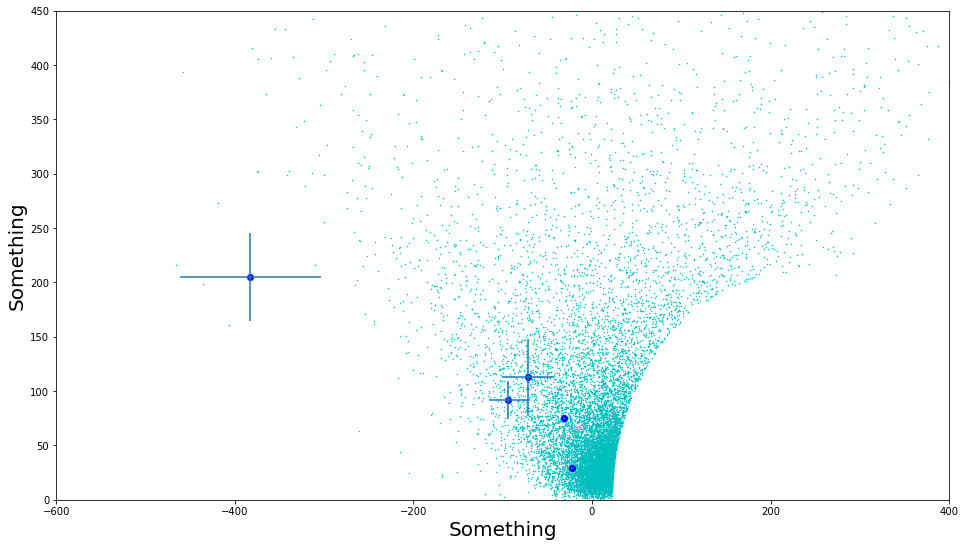

In [26]:
#plt.scatter(df1['vy']+220, t1, color='c',  s = 0.1)
plt.scatter(df_halo_stars['V'], df_halo_stars['T'], color='c',  s = 0.3)
plt.scatter(V, T, color='b')

plt.scatter(V, T, color='b', s = 0.01)


plt.errorbar(V, T, xerr=xerr,yerr=yerr, linestyle="None")

##plt.annotate('Jessicas_star', xy=(-600, 200),  xycoords='data',
##            xytext=(0.8, 0.85), textcoords='figure fraction',
##            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
##            horizontalalignment='right', verticalalignment='top',
##            )

plt.xlabel('Something', fontsize=20)
plt.ylabel('Something', fontsize=20)

plt.xlim(-600,  400)
plt.ylim(0, 450)
plt.show()

In [2]:
# Same with plotly 

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = df_halo_stars['V'],y = df_halo_stars['T'], mode='markers', name = 'something',
    marker=dict(
            color='LightSkyBlue',
            size=6,
)))

fig.add_trace(go.Scatter(
    x=V, y=T,
    mode='markers',
    name='measured',
    error_y=dict(
        type='data', 
        array=xerr,
        color='green',
        thickness=1.5,
        width=3,
    ),
    error_x=dict(
        type='data',
        array = yerr,
        color='green',
        thickness=1.5,
        width=3,
    ),
    marker=dict(color='green', size=2)
))

##fig.add_annotation(x=-600, y=200,
##            text="Jessica's star",
##            showarrow=True,
##            arrowhead=1,
##            yshift=10, xshift = -6, arrowsize=1, ax=-20,
##        ay=-50)
##fig.show()

NameError: name 'df_halo_stars' is not defined

In [9]:
#Read the file with old halo_stars

input_file = open('halo_velocities.txt', 'r')
output_file = open('halo_velocities1.csv', 'w')
for line in input_file:
    (index, vx, vy, vz) = line.strip().split('\x20')
    #print (index, vx, vy, vz)
    output_file.write(','.join([index, vx, vy, vz]) + '\n')
input_file.close()
output_file.close()

In [10]:
t1 = np.sqrt(df1['vx']**2+df1['vz']**2)

NameError: name 'df1' is not defined

In [ ]:
T1 = np.sqrt(np.array(U1)**2+np.array(W1)**2)

dataframe = pd.DataFrame({'V1':V1, 'T1':T1})

In [127]:
t1


0       131.528901
1       117.834645
2        49.292033
3       117.729842
4       178.287377
           ...    
5975     77.021034
5976    160.919345
5977    194.598668
5978    291.706506
5979     73.909413
Length: 5980, dtype: float64